# AP5 - Pattern Recognition
Train a Support Vector Machine (SVM) classifier to recognize 'Abrir', 'Fecahr' and 'Ligar' voice commands.

> Name: Jonas Carvalho Fortes

> Mat: 494513

## Importing Libraries

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sg
import librosa
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from random import choice
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Audio, display

## Auxiliary Functions

In [159]:
def get_audio_signal_from_dataset(df, index):
    """
    Retrieves an audio signal and its class label from a DataFrame containing an audio dataset.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the audio dataset.
        index (int): The index of the audio signal to retrieve.
        
    Returns:
        np.ndarray: The audio signal as a numpy array.
        label (int): The class label for the audio signal.
    """
    signal = df.iloc[index, :-1].values
    label = df.iloc[index, -1]
    return signal, label

In [160]:
def plot_audio_signal(signal, title="Audio Signal"):
    """
    Plots the audio signal as a waveform.
    
    Parameters:
        signal (np.ndarray): The audio signal as a numpy array.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(14, 5))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel("Sample")
    plt.ylabel("Signal Value")
    plt.show()

In [161]:
def play_audio_signal(signal, sample_rate=44100*2.1):
    """
    Plays an audio signal using IPython's Audio display.
    
    Parameters:
        signal (np.ndarray): The audio signal as a numpy array.
        sample_rate (int): The sample rate of the audio signal in Hz. Default is 95900.
    """
    # Normalize the signal to the range [-1, 1] if it's in 16-bit PCM format
    if signal.dtype == np.int16:
        signal = signal / np.iinfo(np.int16).max  # Normalize to the range [-1, 1]
    
    # Display the audio player with the normalized signal
    display(Audio(signal, rate=sample_rate))

In [162]:
def extract_features(audio_signal, sample_rate):
    """
    Extract audio features using scipy.
    
    Parameters:
        audio_signal (np.array): The input audio signal.
        sample_rate (int): The sample rate of the audio signal.
        
    Returns:
        list: A list containing the extracted features for a single audio sample.
    """
    # Ensure the audio signal is of type float32
    audio_signal = audio_signal.astype(np.float32)
    
    # 1. Zero-Crossing Rate (ZCR)
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio_signal))

    # 2. Root Mean Square (RMS) Energy
    rms_energy = np.mean(librosa.feature.rms(y=audio_signal))

    # 3. Mel-Frequency Cepstral Coefficients (MFCC)
    mfccs = np.mean(librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13), axis=1)

    # 4. Chroma
    chroma = np.mean(librosa.feature.chroma_stft(y=audio_signal, sr=sample_rate), axis=1)

    # 5. Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio_signal, sr=sample_rate), axis=1)

    # Combine all features into a list
    features = np.concatenate(([zcr, rms_energy], mfccs, chroma, spectral_contrast))

    return features

In [163]:
def extract_features_from_dataset(df, sample_rate):
    """
    Extract features from a DataFrame containing audio signals.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the audio signals.
        sample_rate (int): Sample rate of the audio signals.
    
    Returns:
        list (np.array): A array containing the extracted features for each signal.
    """
    features_list = []
    
    # Iterate over each row in the DataFrame and extract features
    for _, row in df.iterrows():
        signal = row[:-1].values
        features = extract_features(signal, sample_rate)
        features_list.append(features)
    
    return np.array(features_list)

In [164]:
def plot_pca(X_pca, y):
    """
    Plots the PCA-reduced data with each class in a different color.
    
    Parameters:
        X_pca (np.ndarray): The PCA-reduced data.
        y (np.ndarray): The class labels.
    """
    
    plt.figure(figsize=(8,6))
    
    # Get unique class labels
    unique_classes = np.unique(y)
    
    # Map class labels to names
    class_names = {0: 'class 0 - abrir', 1: 'class 1 - fechar', 2: 'class 2 - ligar'}
    
    for class_label in unique_classes:
        indices = np.where(y == class_label)
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=class_names[class_label], alpha=0.7)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Audio Features')
    plt.legend()
    plt.show()

In [165]:
def grid_search(X, y):
    """
      Makes a grid search to find the best hyperparameters for a SVM model.
      
        Parameters:
            X (np.ndarray): The input features.
            y (np.ndarray): The target labels.
            
        Returns:
            dict: The best hyperparameters found.
            float: The best accuracy found.
    """
    
    # Hiperparameters to search
    kernels = ['linear', 'rbf', 'poly']  # Kernels to test
    C_values = [10**-2, 10**-1, 1, 10, 100]  # Relaxation parameters
    gamma_values = [10**-2, 10**-1, 1, 10, 100]  # gamma parameters
    
    # Store the best hyperparameters and accuracy
    best_accuracy = 0
    best_params = {}
    
    # Make the grid search
    for kernel in kernels:
        for C in C_values:
            for gamma in gamma_values:
                if kernel == 'poly':
                    svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=2)
                else:
                    svm = SVC(kernel=kernel, C=C, gamma=gamma)
                
                # Validation with cross-validation (10 folds)
                scores = cross_val_score(svm, X, y, cv=10, scoring='accuracy')
                
                # Calculate the mean accuracy
                mean_accuracy = np.mean(scores)
                
                # Update the model if the accuracy is better
                if mean_accuracy > best_accuracy:
                    best_accuracy = mean_accuracy
                    best_params = {'kernel': kernel, 'C': C, 'gamma': gamma}
                    if kernel == 'poly':
                        best_params['degree'] = 2

                # Show the results
                print(f"Kernel: {kernel}, C: {C}, Gamma: {gamma}, Acurácia: {mean_accuracy:.4f}")
    
    # Exibir os melhores parâmetros
    print("\nBest Hyperparameters:")
    print(f"Kernel: {best_params['kernel']}, C: {best_params['C']}, Gamma: {best_params['gamma']}")
    if 'degree' in best_params:
        print(f"Degree: {best_params['degree']}")
    print(f"Better Accuracy: {best_accuracy:.4f}")


    return best_params, best_accuracy

In [166]:
def one_vs_all_svm(X, y, best_params, n_folds=10):
    """
    Perform One-vs-All SVM classification with 10-fold cross-validation and return the mean accuracy
    and cumulative confusion matrix.

    Args:
    X (numpy.ndarray): Feature matrix.
    y (numpy.ndarray): Target labels.
    best_params (dict): Dictionary containing the best hyperparameters for the SVM model.
                        Example keys: 'kernel', 'C', 'gamma', 'degree' (optional for polynomial kernel).
    n_folds (int): Number of folds for cross-validation. Default is 10.

    Returns:
    float: Mean accuracy across all folds.
    numpy.ndarray: Cumulative confusion matrix across all folds.
    """
    
    # Get unique classes in the dataset
    classes = np.unique(y)
    
    # Initialize a list to store accuracies for each fold
    accuracies = []
    
    # Initialize the cumulative confusion matrix (len(classes) x len(classes))
    conf_matrix_total = np.zeros((len(classes), len(classes)))
    
    # Set up KFold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Dictionary to store binary classifiers for each class
        classifiers = {}
        
        # Train a binary SVM classifier for each class
        for c in classes:
            # Create binary labels: 1 for the current class, 0 for all other classes
            y_train_bin = np.where(y_train == c, 1, 0)
            
            # Train the SVM classifier with the best hyperparameters
            svm = SVC(kernel=best_params['kernel'], 
                      C=best_params['C'], 
                      gamma=best_params['gamma'],
                      degree=best_params.get('degree', 3),  # Default degree of 3 for polynomial kernel
                      probability=True)  # Enable probability prediction
            
            # Fit the SVM model to the binary labels
            svm.fit(X_train, y_train_bin)
            
            # Store the trained classifier
            classifiers[c] = svm
        
        # Make predictions on the test set
        y_pred = []
        for i in range(len(X_test)):
            # Get predicted probabilities from each classifier
            probas = {}
            for c, classifier in classifiers.items():
                probas[c] = classifier.predict_proba(X_test[i].reshape(1, -1))[0][1]  # Probability of class 1
            
            # Choose the class with the highest probability
            max_prob = max(probas.values())
            possible_classes = [cls for cls, prob in probas.items() if prob == max_prob]
            
            # In case of a tie, choose a class randomly
            predicted_class = choice(possible_classes)
            y_pred.append(predicted_class)
        
        # Calculate accuracy for the current fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        # Update the cumulative confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)
        conf_matrix_total += conf_matrix
    
    # Calculate the mean accuracy across all folds
    mean_accuracy = np.mean(accuracies)
    
    print(f"Mean accuracy of One-vs-All with {n_folds}-fold cross-validation: {mean_accuracy:.4f}")
    
    return mean_accuracy, conf_matrix_total

In [167]:
def plot_confusion_matrix(conf_matrix, classes):
    """
        Plot a confusion matrix as a heatmap.
    
        Parameters:
            conf_matrix (np.ndarray): The confusion matrix.
            classes (list): The class labels.
    """
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - One-vs-All SVM')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

## Feature extraction and PCA

### Load Dataset

In [168]:
# Path to the CSV file containing the audio dataset
file_path = "data/audio_signals_dataset.csv"

# Read the dataset from the CSV file
df = pd.read_csv(file_path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,99991,99992,99993,99994,99995,99996,99997,99998,99999,label
0,18770,17990,-1,-1,16727,17750,28006,8308,16,0,...,-317,-16,-361,-46,-341,-18,-379,-46,-359,0
1,18770,17990,-1,-1,16727,17750,28006,8308,16,0,...,-501,-240,-490,-243,-478,-251,-488,-265,-508,0
2,18770,17990,-1,-1,16727,17750,28006,8308,16,0,...,-436,105,-417,142,-426,98,-443,146,-439,0
3,18770,17990,-1,-1,16727,17750,28006,8308,16,0,...,-601,443,-592,433,-595,384,-607,405,-603,0
4,18770,17990,-1,-1,16727,17750,28006,8308,16,0,...,-563,-136,-559,-136,-566,-124,-548,-150,-559,0


### Plotting the audio signals

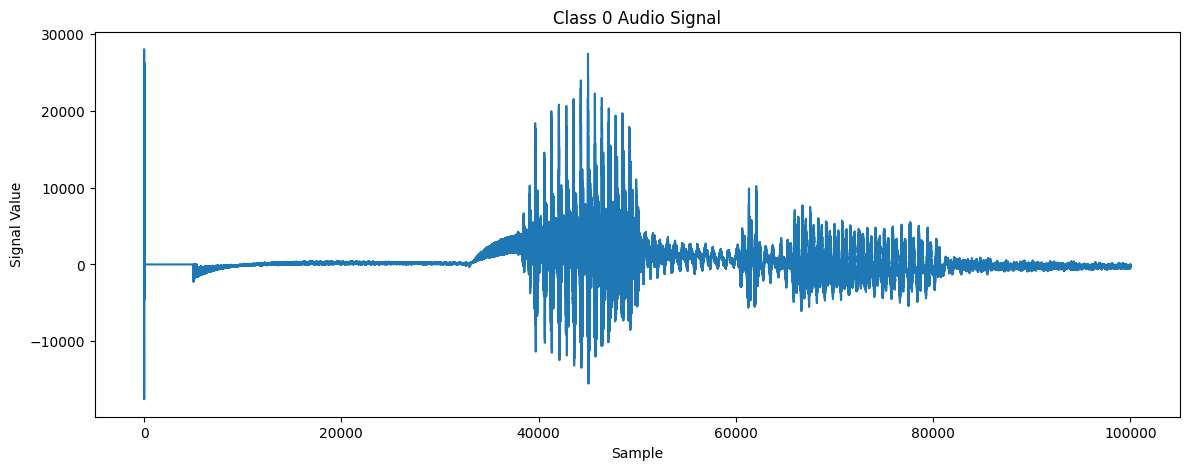

In [180]:
# Plot a sample audio signal from the dataset - class 0
audio_index = 0 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plot the audio signal
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

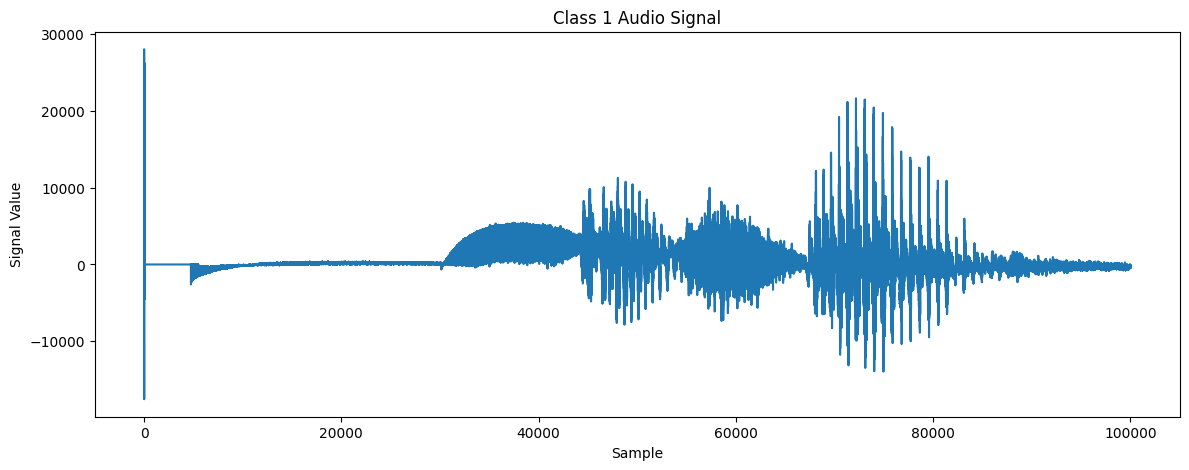

In [173]:
# Plot a sample audio signal from the dataset - class 1

audio_index = 15 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plot the audio signal
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

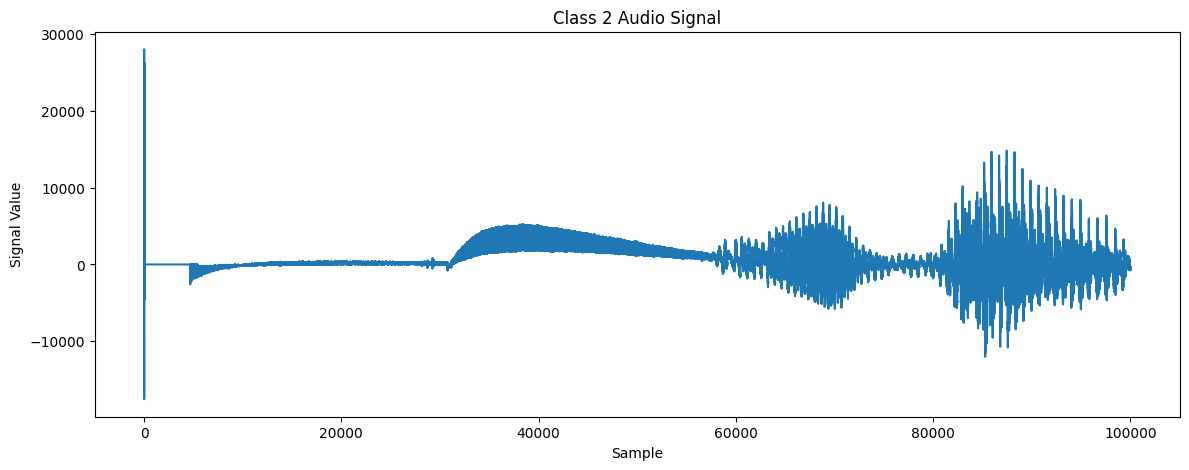

In [179]:
# Plot a sample audio signal from the dataset - class 2

audio_index = 30 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plot the audio signal
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

### PCA Analysis

In [181]:
# Extract features from the dataset
X = extract_features_from_dataset(df, sample_rate=44100*2.1)
y = df['label'].values

In [182]:
# 1. Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [183]:
# 2. Apply PCA
pca = PCA(n_components=2)  # Reduzindo para 2 componentes principais
X_pca = pca.fit_transform(X_scaled)

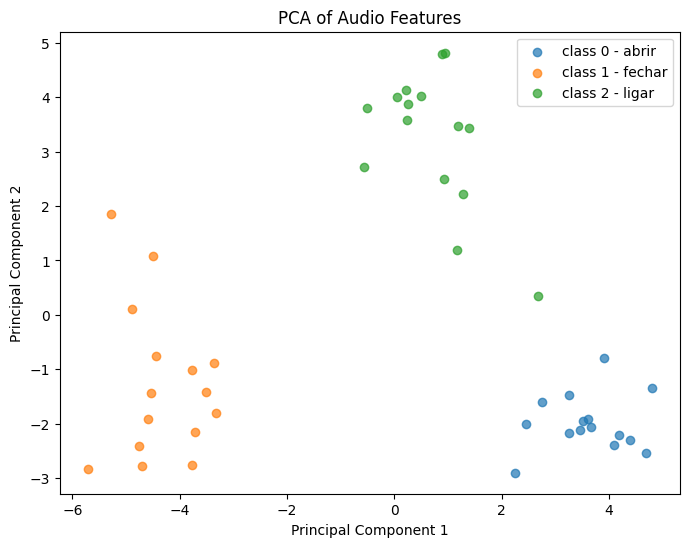

In [184]:
# Plot the PCA-reduced data
plot_pca(X_pca, y)

## Model Tunning and Training

In [185]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [186]:
# Find the best hyperparameters for the SVM model by grid search
best_params, best_accuracy = grid_search(X_train, y_train)

Kernel: linear, C: 0.01, Gamma: 0.01, Acurácia: 0.9500
Kernel: linear, C: 0.01, Gamma: 0.1, Acurácia: 0.9500
Kernel: linear, C: 0.01, Gamma: 1, Acurácia: 0.9500
Kernel: linear, C: 0.01, Gamma: 10, Acurácia: 0.9500
Kernel: linear, C: 0.01, Gamma: 100, Acurácia: 0.9500
Kernel: linear, C: 0.1, Gamma: 0.01, Acurácia: 0.9500
Kernel: linear, C: 0.1, Gamma: 0.1, Acurácia: 0.9500
Kernel: linear, C: 0.1, Gamma: 1, Acurácia: 0.9500
Kernel: linear, C: 0.1, Gamma: 10, Acurácia: 0.9500
Kernel: linear, C: 0.1, Gamma: 100, Acurácia: 0.9500
Kernel: linear, C: 1, Gamma: 0.01, Acurácia: 0.9500
Kernel: linear, C: 1, Gamma: 0.1, Acurácia: 0.9500
Kernel: linear, C: 1, Gamma: 1, Acurácia: 0.9500
Kernel: linear, C: 1, Gamma: 10, Acurácia: 0.9500
Kernel: linear, C: 1, Gamma: 100, Acurácia: 0.9500
Kernel: linear, C: 10, Gamma: 0.01, Acurácia: 0.9500
Kernel: linear, C: 10, Gamma: 0.1, Acurácia: 0.9500
Kernel: linear, C: 10, Gamma: 1, Acurácia: 0.9500
Kernel: linear, C: 10, Gamma: 10, Acurácia: 0.9500
Kernel: li

## One vs All SVM Classifier

In [189]:
# Classify the dataset using One-vs-All SVM with 10-fold cross-validation
mean_accuracy, conf_matrix_total = one_vs_all_svm(X, y, best_params, n_folds=10)

Mean accuracy of One-vs-All with 10-fold cross-validation: 0.9550


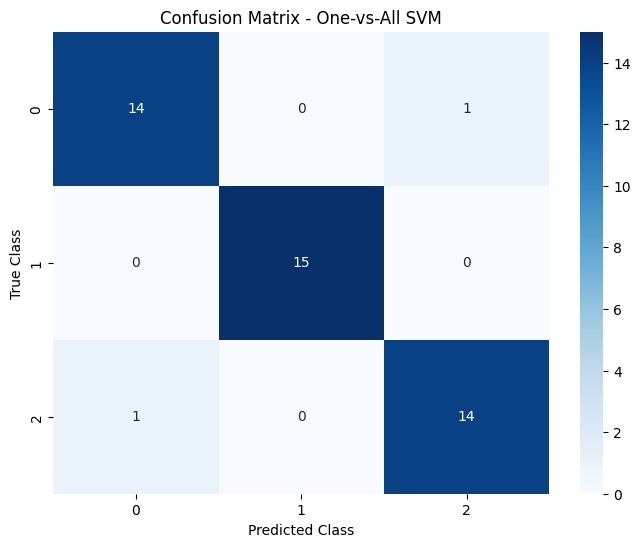

Mean accuracy: 95.5%


In [190]:
# Plot the confusion matrix
plot_confusion_matrix(conf_matrix_total, np.unique(y_train))

print(f"Mean accuracy: {mean_accuracy*100:.1f}%")